In [1]:
from pynq import Overlay
from pynq import allocate
import numpy as np
import cv2
import time
from PIL import Image
from utility import util
from matplotlib import pyplot as plt
import rnet_weights
import onet_weights

ERROR: Unknown command: 'dump'


In [2]:
overlay = Overlay("mtcnn_base.bit")

In [3]:
overlay?

In [4]:
pnet = overlay.pnet_accel_0
rnet = overlay.rnet_accel_0
onet_conv1 = overlay.conv_1_accel_0
onet = overlay.onet_accel_0

In [5]:
pnet.register_map
# rnet.register_map
# onet_conv1.register_map
# onet.register_map

RegisterMap {
  CTRL = Register(AP_START=0, AP_DONE=0, AP_IDLE=1, AP_READY=0, RESERVED_1=0, AUTO_RESTART=0, RESERVED_2=0, INTERRUPT=0, RESERVED_3=0),
  GIER = Register(Enable=0, RESERVED=0),
  IP_IER = Register(CHAN0_INT_EN=0, CHAN1_INT_EN=0, RESERVED_0=0),
  IP_ISR = Register(CHAN0_INT_ST=0, CHAN1_INT_ST=0, RESERVED_0=0),
  input_r_1 = Register(input_r=write-only),
  input_r_2 = Register(input_r=write-only),
  output1_1 = Register(output1=write-only),
  output1_2 = Register(output1=write-only),
  output2_1 = Register(output2=write-only),
  output2_2 = Register(output2=write-only)
}

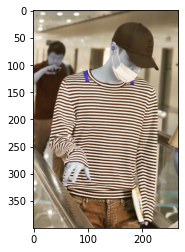

In [6]:
image1 = cv2.imread("image.png", cv2.IMREAD_COLOR)
plt.imshow(image1)
plt.show()

In [7]:
image1 = cv2.resize(image1, (12,12), interpolation = cv2.INTER_LINEAR)
image1 = util.preprocess(image1)
print(image1)

[[[[ 0.23046875  0.12109375  0.11328125  0.06640625 -0.11328125
    -0.33203125 -0.19921875 -0.28515625 -0.42578125 -0.41015625
    -0.42578125 -0.44921875]
   [ 0.89453125  0.21484375  0.00390625  0.16796875  0.27734375
     0.23046875  0.22265625 -0.73828125 -0.69140625 -0.67578125
     0.27734375  0.26171875]
   [ 0.49609375  0.07421875 -0.55078125 -0.42578125  0.41015625
    -0.60546875  0.46484375  0.31640625 -0.71484375 -0.77734375
     0.24609375  0.00390625]
   [ 0.41796875 -0.26171875 -0.87890625 -0.17578125 -0.64453125
     0.53515625  0.05859375  0.80859375  0.55078125 -0.30078125
    -0.30078125  0.16796875]
   [-0.87109375 -0.87109375  0.75390625  0.58984375  0.48046875
    -0.30078125  0.70703125  0.68359375 -0.34765625  0.62109375
    -0.44140625  0.11328125]
   [-0.88671875 -0.89453125 -0.37109375 -0.29296875  0.32421875
    -0.23046875 -0.74609375  0.56640625 -0.64453125  0.63671875
    -0.45703125 -0.03515625]
   [-0.58203125 -0.66796875 -0.19140625 -0.74609375 -0.074

In [8]:
def pnet_driver(in_image):
    in_image_buffer = allocate(shape=(1,3,12,12), dtype=np.float32, cacheable=False)
    out1_buffer = allocate(shape=(2), dtype=np.float32, cacheable=False)
    out2_buffer = allocate(shape=(4), dtype=np.float32, cacheable=False)
    
    in_image_buffer[:] = in_image
    out1_buffer[:] = np.zeros(shape=(2), dtype=np.float32)
    out2_buffer[:] = np.zeros(shape=(4), dtype=np.float32)
    
    pnet.register_map.input_r_1 = in_image_buffer.device_address
    pnet.register_map.output1_1 = out1_buffer.device_address
    pnet.register_map.output2_1 = out2_buffer.device_address
    HWTimeStart = time.perf_counter()
    if(pnet.register_map.CTRL.AP_IDLE == 1):
        pnet.register_map.CTRL.AP_START = 1
    while(pnet.register_map.CTRL.AP_IDLE != 1):
        continue
    print("HW runtime: ", time.perf_counter() - HWTimeStart)
    out1 = out1_buffer
    out2 = out2_buffer
    
    in_image_buffer.freebuffer()
    out1_buffer.freebuffer()
    out2_buffer.freebuffer()
    return out1, out2

In [9]:
out1, out2 = pnet_driver(image1)
print(out1)
print(out2)

HW runtime:  0.005436183999904642
[ 3.9584792 -2.4977105]
[ 0.14916381  0.0235634  -0.22546148 -0.13162974]


In [10]:
rnet.register_map

RegisterMap {
  CTRL = Register(AP_START=0, AP_DONE=0, AP_IDLE=1, AP_READY=0, RESERVED_1=0, AUTO_RESTART=0, RESERVED_2=0, INTERRUPT=0, RESERVED_3=0),
  GIER = Register(Enable=0, RESERVED=0),
  IP_IER = Register(CHAN0_INT_EN=0, CHAN1_INT_EN=0, RESERVED_0=0),
  IP_ISR = Register(CHAN0_INT_ST=0, CHAN1_INT_ST=0, RESERVED_0=0),
  input_r_1 = Register(input_r=write-only),
  input_r_2 = Register(input_r=write-only),
  conv_mp_2_weights_1 = Register(conv_mp_2_weights=write-only),
  conv_mp_2_weights_2 = Register(conv_mp_2_weights=write-only),
  conv_3_weights_1 = Register(conv_3_weights=write-only),
  conv_3_weights_2 = Register(conv_3_weights=write-only),
  dense_1_weights_1 = Register(dense_1_weights=write-only),
  dense_1_weights_2 = Register(dense_1_weights=write-only),
  output1_1 = Register(output1=write-only),
  output1_2 = Register(output1=write-only),
  output2_1 = Register(output2=write-only),
  output2_2 = Register(output2=write-only)
}

In [11]:
def rnet_driver(in_image, conv_mp_2_weights, conv_3_weights, dense_1_weights):
    in_image_buffer = allocate(shape=(1,3,24,24), dtype=np.float32, cacheable=False)
    
    conv_mp_2_weights_buffer = allocate(shape=(12096), dtype=np.float32, cacheable=False)
    conv_3_weights_buffer = allocate(shape=(12288), dtype=np.float32, cacheable=False)
    dense_1_weights_buffer = allocate(shape=(73728), dtype=np.float32, cacheable=False)
    
    out1_buffer = allocate(shape=(2), dtype=np.float32, cacheable=False)
    out2_buffer = allocate(shape=(4), dtype=np.float32, cacheable=False)
    
    in_image_buffer[:] = in_image
    
    conv_mp_2_weights_buffer[:] = conv_mp_2_weights
    conv_3_weights_buffer[:] = conv_3_weights
    dense_1_weights_buffer[:] = dense_1_weights
    
    out1_buffer[:] = np.zeros(shape=(2), dtype=np.float32)
    out2_buffer[:] = np.zeros(shape=(4), dtype=np.float32)
    
    rnet.register_map.input_r_1 = in_image_buffer.device_address
    
    rnet.register_map.conv_mp_2_weights_1 = conv_mp_2_weights_buffer.device_address
    rnet.register_map.conv_3_weights_1 = conv_3_weights_buffer.device_address
    rnet.register_map.dense_1_weights_1 = dense_1_weights_buffer.device_address
    
    rnet.register_map.output1_1 = out1_buffer.device_address
    rnet.register_map.output2_1 = out2_buffer.device_address
    
    HWTimeStart = time.perf_counter()
    if(rnet.register_map.CTRL.AP_IDLE == 1):
        rnet.register_map.CTRL.AP_START = 1
    while(rnet.register_map.CTRL.AP_IDLE != 1):
        continue
    print("HW runtime: ", time.perf_counter() - HWTimeStart)
    out1 = out1_buffer
    out2 = out2_buffer
    
    in_image_buffer.freebuffer()
    out1_buffer.freebuffer()
    out2_buffer.freebuffer()
    return out1, out2

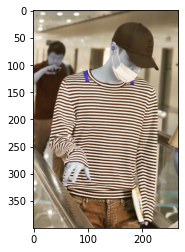

In [12]:
image2 = cv2.imread("image.png", cv2.IMREAD_COLOR)
plt.imshow(image2)
plt.show()

In [13]:
image2 = cv2.resize(image2, (24,24), interpolation=cv2.INTER_LINEAR)
image2 = util.preprocess(image2)
print(image2.shape)

(1, 3, 24, 24)


In [14]:
out1, out2 = rnet_driver(image2, rnet_weights.conv_mp_2_weights, rnet_weights.conv_3_weights, rnet_weights.dense_1_weights)
print(out1)
print(out2)

HW runtime:  0.13878011099996002
[ 2.3296456 -2.3278503]
[ 0.20825452  0.20260608 -0.1397379   0.04163105]


In [15]:
onet_conv1.register_map

RegisterMap {
  CTRL = Register(AP_START=0, AP_DONE=0, AP_IDLE=1, AP_READY=0, RESERVED_1=0, AUTO_RESTART=0, RESERVED_2=0, INTERRUPT=0, RESERVED_3=0),
  GIER = Register(Enable=0, RESERVED=0),
  IP_IER = Register(CHAN0_INT_EN=0, CHAN1_INT_EN=0, RESERVED_0=0),
  IP_ISR = Register(CHAN0_INT_ST=0, CHAN1_INT_ST=0, RESERVED_0=0),
  input_r_1 = Register(input_r=write-only),
  input_r_2 = Register(input_r=write-only),
  output_r_1 = Register(output_r=write-only),
  output_r_2 = Register(output_r=write-only)
}

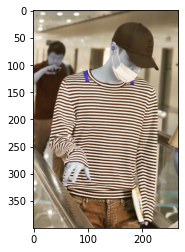

In [16]:
image3 = cv2.imread("image.png", cv2.IMREAD_COLOR)
plt.imshow(image3)
plt.show()

In [17]:
image3 = cv2.resize(image3, (48, 48), interpolation=cv2.INTER_LINEAR)
image3 = util.preprocess(image3)
print(image3)

[[[[ 0.21484375  0.16015625  0.28515625 ... -0.44921875 -0.43359375
    -0.41796875]
   [ 0.23828125  0.11328125  0.25390625 ... -0.44140625 -0.42578125
    -0.40234375]
   [ 0.31640625  0.29296875  0.94140625 ... -0.40234375 -0.39453125
    -0.38671875]
   ...
   [-0.23046875  0.06640625 -0.14453125 ... -0.58203125 -0.62109375
    -0.58984375]
   [-0.22265625 -0.20703125 -0.19921875 ... -0.53515625 -0.58984375
     0.12109375]
   [-0.20703125 -0.21484375 -0.21484375 ...  0.36328125  0.38671875
     0.34765625]]

  [[ 0.34765625  0.30859375  0.41796875 ... -0.25390625 -0.24609375
    -0.25390625]
   [ 0.36328125  0.25390625  0.37890625 ... -0.24609375 -0.23828125
    -0.24609375]
   [ 0.47265625  0.47265625  0.98046875 ... -0.17578125 -0.17578125
    -0.18359375]
   ...
   [-0.01171875  0.26953125  0.06640625 ... -0.42578125 -0.44140625
    -0.41796875]
   [-0.01953125 -0.01171875  0.03515625 ... -0.34765625 -0.44140625
     0.27734375]
   [ 0.00390625  0.01171875  0.03515625 ...  0.51

In [18]:
onet.register_map

RegisterMap {
  CTRL = Register(AP_START=0, AP_DONE=0, AP_IDLE=1, AP_READY=0, RESERVED_1=0, AUTO_RESTART=0, RESERVED_2=0, INTERRUPT=0, RESERVED_3=0),
  GIER = Register(Enable=0, RESERVED=0),
  IP_IER = Register(CHAN0_INT_EN=0, CHAN1_INT_EN=0, RESERVED_0=0),
  IP_ISR = Register(CHAN0_INT_ST=0, CHAN1_INT_ST=0, RESERVED_0=0),
  input_r_1 = Register(input_r=write-only),
  input_r_2 = Register(input_r=write-only),
  conv_mp_2_weights_1 = Register(conv_mp_2_weights=write-only),
  conv_mp_2_weights_2 = Register(conv_mp_2_weights=write-only),
  conv_mp_3_weights_1 = Register(conv_mp_3_weights=write-only),
  conv_mp_3_weights_2 = Register(conv_mp_3_weights=write-only),
  conv_4_weights_1 = Register(conv_4_weights=write-only),
  conv_4_weights_2 = Register(conv_4_weights=write-only),
  dense_1_weights_1 = Register(dense_1_weights=write-only),
  dense_1_weights_2 = Register(dense_1_weights=write-only),
  output1_1 = Register(output1=write-only),
  output1_2 = Register(output1=write-only),
  outpu

In [19]:
def onet_driver(in_image, conv_mp_2_weights, conv_mp_3_weights, conv_4_weights, dense_1_weights):
    #First conv layer for onet
    in_image_buffer = allocate(shape=(1,3,48,48), dtype=np.float32, cacheable=False)
    out_conv_buffer = allocate(shape=(1,32,46,46), dtype=np.float32, cacheable=False)
    
    in_image_buffer[:] = in_image
    out_conv_buffer[:] = np.zeros(shape=(1,32,46,46), dtype=np.float32)
    
    onet_conv1.register_map.input_r_1 = in_image_buffer.device_address
    onet_conv1.register_map.output_r_1 = out_conv_buffer.device_address
    HWTimeStart = time.perf_counter()
    if(onet_conv1.register_map.CTRL.AP_IDLE == 1):
        onet_conv1.register_map.CTRL.AP_START = 1
    while(onet_conv1.register_map.CTRL.AP_IDLE != 1):
        continue
    print("HW runtime: ", time.perf_counter() - HWTimeStart)
    
    
    #The rest of onet
#     in_image_buffer = allocate(shape=(1,3,48,48), dtype=np.float32, cacheable=False)
    
    conv_mp_2_weights_buffer = allocate(shape=(18432), dtype=np.float32, cacheable=False)
    conv_mp_3_weights_buffer = allocate(shape=(36864), dtype=np.float32, cacheable=False)
    conv_4_weights_buffer = allocate(shape=(32768), dtype=np.float32, cacheable=False)
    dense_1_weights_buffer = allocate(shape=(294912), dtype=np.float32, cacheable=False)
    
    out1_buffer = allocate(shape=(2), dtype=np.float32, cacheable=False)
    out2_buffer = allocate(shape=(4), dtype=np.float32, cacheable=False)
    out3_buffer = allocate(shape=(10), dtype=np.float32, cacheable=False)
    
    conv_mp_2_weights_buffer[:] = conv_mp_2_weights
    conv_mp_3_weights_buffer[:] = conv_mp_3_weights
    conv_4_weights_buffer[:] = conv_4_weights
    dense_1_weights_buffer[:] = dense_1_weights
    
    out1_buffer[:] = np.zeros(shape=(2), dtype=np.float32)
    out2_buffer[:] = np.zeros(shape=(4), dtype=np.float32)
    out3_buffer[:] = np.zeros(shape=(10), dtype=np.float32)
    
    onet.register_map.input_r_1 = out_conv_buffer.device_address
    
    onet.register_map.conv_mp_2_weights_1 = conv_mp_2_weights_buffer.device_address
    onet.register_map.conv_mp_3_weights_1 = conv_mp_3_weights_buffer.device_address
    onet.register_map.conv_4_weights_1 = conv_4_weights_buffer.device_address
    onet.register_map.dense_1_weights_1 = dense_1_weights_buffer.device_address
    
    onet.register_map.output1_1 = out1_buffer.device_address
    onet.register_map.output2_1 = out2_buffer.device_address
    onet.register_map.output3_1 = out3_buffer.device_address
    
    HWTimeStart = time.perf_counter()
    if(onet.register_map.CTRL.AP_IDLE == 1):
        onet.register_map.CTRL.AP_START = 1
    while(onet.register_map.CTRL.AP_IDLE != 1):
        continue
    print("HW runtime: ", time.perf_counter() - HWTimeStart)
    out1 = out1_buffer
    out2 = out2_buffer
    out3 = out3_buffer
#     print(out1_buffer)
    
    in_image_buffer.freebuffer()
    out_conv_buffer.freebuffer()
    
    conv_mp_2_weights_buffer.freebuffer()
    conv_mp_3_weights_buffer.freebuffer()
    conv_4_weights_buffer.freebuffer()
    dense_1_weights_buffer.freebuffer()
    
    out1_buffer.freebuffer()
    out2_buffer.freebuffer()
    out3_buffer.freebuffer()
    return out1, out2, out3

In [20]:

out1, out2, out3 = onet_driver(image3, onet_weights.conv_mp_2_weights, onet_weights.conv_mp_3_weights, onet_weights.conv_4_weights, onet_weights.dense_1_weights)
print(out1)
print(out2)
print(out3)

HW runtime:  0.10560206099989955
HW runtime:  0.9525756850000562
[ 4.295994  -4.2924557]
[ 0.04294189 -0.26979434 -0.06687679 -0.09062712]
[0.2362439  0.6512361  0.49681574 0.3453007  0.7258401  0.22015935
 0.14061823 0.33916557 0.7433947  0.6830009 ]
